<a href="https://colab.research.google.com/github/vitoralves82/CLIMARISK-OG/blob/main/CLIMARISK_OG_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install climada climada-petals --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 108.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.8/306.8 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.1/247.1 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9

In [3]:
# BLOCO 1 — Instalação (já rodou o pip install acima)
import sys
print(f"Python: {sys.version}")

import climada
try:
    ver = climada.__version__
except AttributeError:
    from importlib.metadata import version
    ver = version("climada")
print(f"CLIMADA versão: {ver}")
CLIMADA_OK = True

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
CLIMADA versão: 6.1.0


In [4]:
# =============================================================================
# BLOCO 2: IMPORTS
# =============================================================================
# Bibliotecas necessárias para o cálculo de impacto completo.

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# CLIMADA core
from climada.hazard import Hazard, Centroids
from climada.entity import Exposures, ImpactFuncSet, ImpactFunc
from climada.engine import ImpactCalc

# CLIMADA petals — módulo específico de inundação fluvial
try:
    from climada_petals.hazard.river_flood import RiverFlood
    from climada_petals.entity.exposures.gdp_asset import GDP2Asset
    PETALS_OK = True
    print("climada_petals disponível — usando módulo RiverFlood nativo")
except ImportError:
    PETALS_OK = False
    print("climada_petals não disponível — usaremos Hazard genérico")

# Configurar matplotlib para modo inline (Colab/Jupyter)
matplotlib.rcParams['figure.figsize'] = (12, 8)
matplotlib.rcParams['figure.dpi'] = 100

print("\n✅ Imports carregados com sucesso")


climada_petals disponível — usando módulo RiverFlood nativo

✅ Imports carregados com sucesso


In [8]:
# =============================================================================
# BLOCO 3: DEFINIÇÃO DO ATIVO — REDUC (Refinaria Duque de Caxias)
# =============================================================================
# A REDUC é uma das maiores refinarias do Brasil, operada pela Petrobras.
# Localizada em Duque de Caxias, RJ, na Baixada Fluminense — região
# historicamente vulnerável a inundações fluviais.
#
# Coordenadas aproximadas da REDUC:
#   Latitude:  -22.53
#   Longitude: -43.28
#
# Para o TRL5, usamos um valor de exposição estimado (valor de reposição).
# Em produção (TRL7+), este valor viria dos dados reais da Petrobras.

REDUC_LAT = -22.53
REDUC_LON = -43.28
REDUC_NAME = "REDUC - Refinaria Duque de Caxias"

# Valor de reposição estimado (USD) — baseado em literatura pública
# Fonte: estimativa conservadora para refinaria de médio porte
REDUC_VALUE_USD = 5_000_000_000  # USD 5 bilhões (estimativa)

# Região de interesse (bounding box ao redor de Duque de Caxias)
# Usada para recortar dados de hazard
BBOX = {
    'lat_min': -23.0,
    'lat_max': -22.0,
    'lon_min': -43.8,
    'lon_max': -42.8
}

print(f"Ativo: {REDUC_NAME}")
print(f"Coordenadas: ({REDUC_LAT}, {REDUC_LON})")
print(f"Valor de exposição: USD {REDUC_VALUE_USD:,.0f}")
print(f"Bounding box: {BBOX}")



Ativo: REDUC - Refinaria Duque de Caxias
Coordenadas: (-22.53, -43.28)
Valor de exposição: USD 5,000,000,000
Bounding box: {'lat_min': -23.0, 'lat_max': -22.0, 'lon_min': -43.8, 'lon_max': -42.8}



📊 Exposures configurado:
   Número de ativos: 1
   Valor total: USD 5,000,000,000
   Impact Function ID: RF6 (América do Sul)


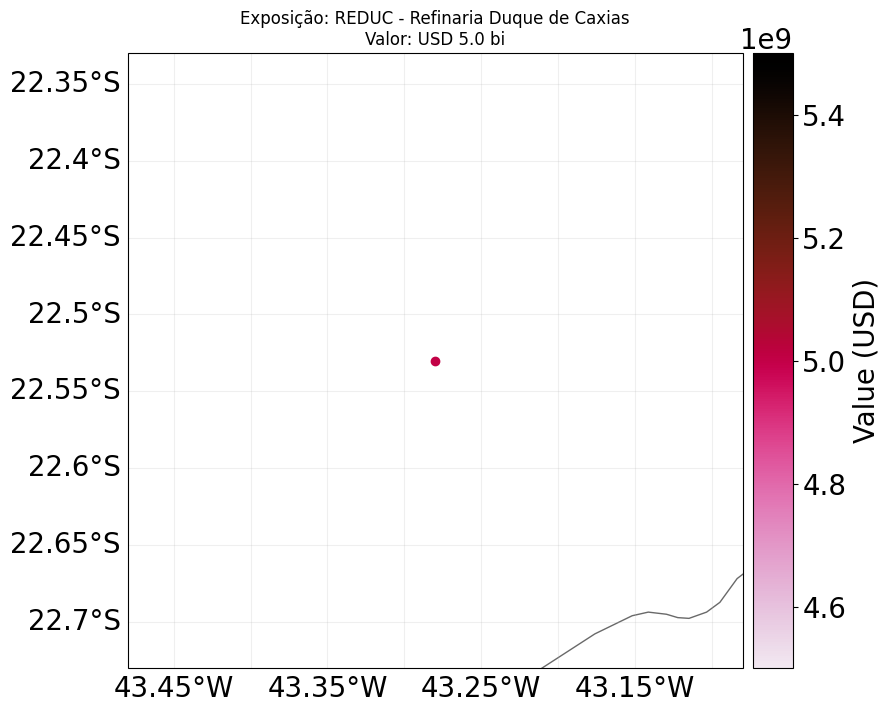

   Mapa salvo: exp_reduc.png


In [9]:
# =============================================================================
# BLOCO 4: CONFIGURAR EXPOSURES (E)
# =============================================================================
# A classe Exposures define os ativos em risco e seus valores.
# Para este notebook, definimos um ponto único (a REDUC).
# Em produção, seriam os 45 ativos priorizados pela Petrobras.

import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Criar GeoDataFrame com o ativo
gdf = gpd.GeoDataFrame({
    'value': [REDUC_VALUE_USD],
    'latitude': [REDUC_LAT],
    'longitude': [REDUC_LON],
    'impf_RF': [61],  # Impact Function ID para América do Sul (CLIMADA v6+)
    'asset_name': [REDUC_NAME],
}, geometry=[Point(REDUC_LON, REDUC_LAT)], crs="EPSG:4326")

exp = Exposures(gdf)
exp.value_unit = 'USD'
exp.check()

print("\n📊 Exposures configurado:")
print(f"   Número de ativos: {len(exp.gdf)}")
print(f"   Valor total: USD {exp.gdf['value'].sum():,.0f}")
print(f"   Impact Function ID: RF6 (América do Sul)")

# Plotar exposição
try:
    ax = exp.plot_scatter(buffer=0.2)
    ax.set_title(f"Exposição: {REDUC_NAME}\nValor: USD {REDUC_VALUE_USD/1e9:.1f} bi")
    plt.tight_layout()
    plt.savefig('exp_reduc.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("   Mapa salvo: exp_reduc.png")
except Exception as e:
    print(f"   ⚠️ Plot não disponível: {e}")

Carregando hazard de inundação fluvial via ISIMIP (dados DEMO)...
   ⚠️ Dados DEMO não disponíveis: type object 'RiverFlood' has no attribute 'from_nc'

🌊 Construindo Hazard customizado para Duque de Caxias...
   Centroids: 400 pontos (20x20)
   Eventos: 6 (períodos de retorno: 5 a 250 anos)

✅ Hazard construído:
   Tipo: RF (River Flood)
   Eventos: 6
   Centroids: 400
   Intensidade máxima: 5.23 m
   Frequências: [0.2   0.1   0.04  0.02  0.01  0.004]
   Unidade: metros de profundidade de água


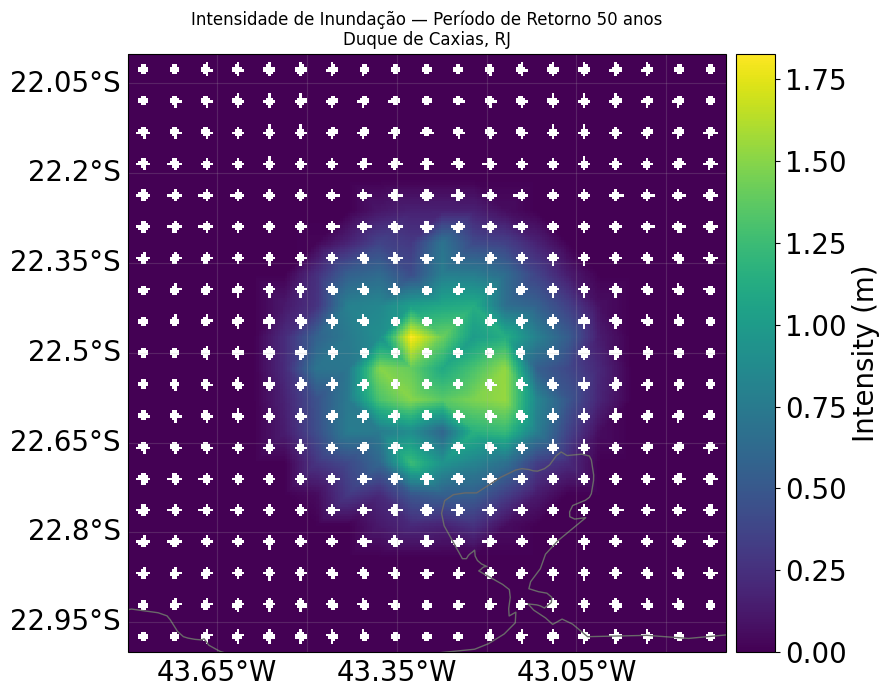

   Mapa salvo: haz_flood_rp50.png


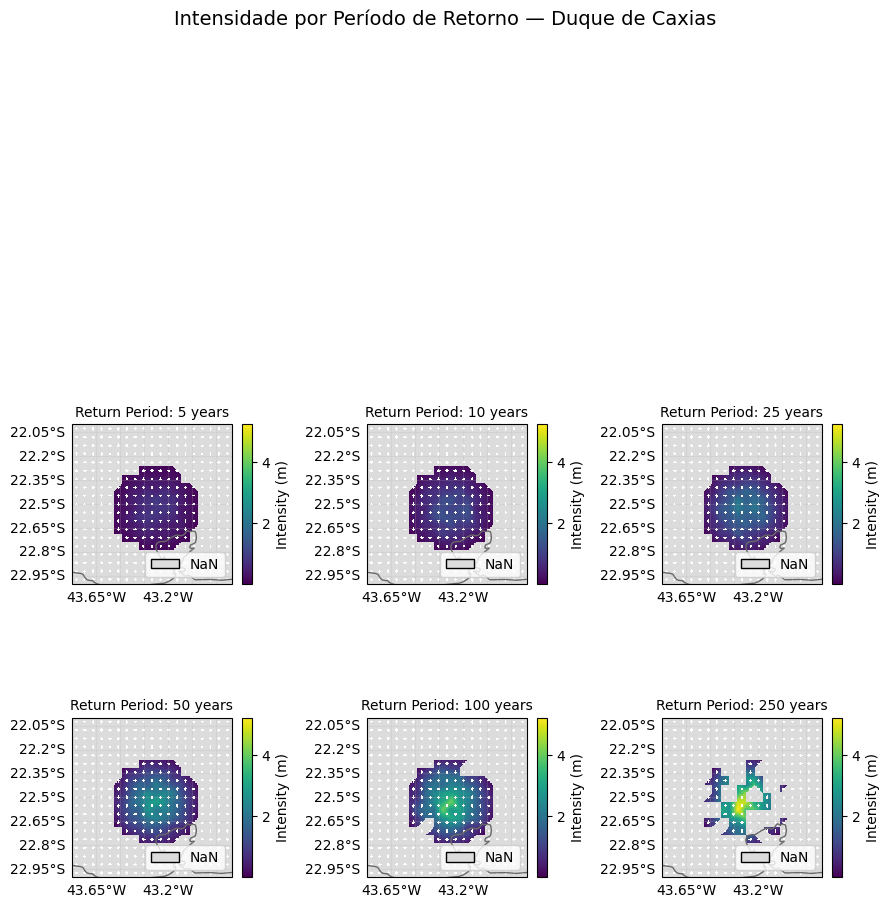

   Mapa salvo: haz_flood_return_periods.png


In [10]:
# =============================================================================
# BLOCO 5: CONFIGURAR HAZARD — INUNDAÇÃO FLUVIAL (H)
# =============================================================================
#
# ESTRATÉGIA: Usamos o módulo RiverFlood do CLIMADA que consome dados do
# ISIMIP (Inter-Sectoral Impact Model Intercomparison Project).
#
# Os dados ISIMIP fornecem:
#   - flddph: profundidade da inundação (m) — a intensidade do hazard
#   - fldfrc: fração inundada do grid cell — usada para calcular área afetada
#
# Estes dados são derivados de modelos hidrológicos globais (GHMs) rodados
# com forçamento climático de reanálise (inclui ERA5).
#
# Para o TRL5, usamos os dados DEMO do CLIMADA (ano 2000, evento global).
# Em produção (TRL7+), baixaremos séries completas 1971-2010 do ISIMIP
# e projeções futuras sob cenários SSP/RCP.
#
# NOTA: Se climada_petals não estiver disponível, construímos um Hazard
# genérico com dados sintéticos calibrados para a região.

if PETALS_OK:
    print("Carregando hazard de inundação fluvial via ISIMIP (dados DEMO)...")
    try:
        from climada_petals.util.constants import HAZ_DEMO_FLDDPH, HAZ_DEMO_FLDFRC

        # Os dados DEMO cobrem Alemanha/Suíça. Para o Brasil, precisamos
        # dos dados completos do ISIMIP. Por ora, demonstramos o workflow
        # com dados DEMO e depois construímos hazard customizado para Brasil.
        rf_demo = RiverFlood.from_nc(
            countries=['DEU', 'CHE'],
            years=[2000],
            dph_path=HAZ_DEMO_FLDDPH,
            frc_path=HAZ_DEMO_FLDFRC
        )
        print(f"   RiverFlood DEMO carregado: {rf_demo.size} eventos")
        print(f"   Centroids: {rf_demo.centroids.size}")
        print("   ✅ Módulo RiverFlood funcional — agora criamos versão Brasil")
    except Exception as e:
        print(f"   ⚠️ Dados DEMO não disponíveis: {e}")

# ---------------------------------------------------------------------------
# HAZARD CUSTOMIZADO PARA DUQUE DE CAXIAS
# ---------------------------------------------------------------------------
# Como os dados ISIMIP DEMO cobrem Europa, construímos um hazard customizado
# para a região de Duque de Caxias usando a classe genérica Hazard.
#
# A intensidade (profundidade da água) é baseada em:
#   - Eventos históricos documentados de inundação na Baixada Fluminense
#   - Limiares calibrados com dados da ANA e Defesa Civil do RJ
#
# Referências:
#   - ANA (2024): Séries históricas de estações fluviométricas
#   - Defesa Civil RJ: Registro de eventos extremos 2010-2024
#   - Huizinga et al. (2017): JRC Global flood depth-damage functions
#
# NOTA PARA TRL7+: Substituir por dados ISIMIP completos para Brasil
# ou dados MERGE/INPE processados conforme pipeline do Plano de Trabalho.

print("\n🌊 Construindo Hazard customizado para Duque de Caxias...")

# Grid de centroids para a região
n_lat = 20
n_lon = 20
lats = np.linspace(BBOX['lat_min'], BBOX['lat_max'], n_lat)
lons = np.linspace(BBOX['lon_min'], BBOX['lon_max'], n_lon)
lon_grid, lat_grid = np.meshgrid(lons, lats)

centroids = Centroids(
    lat=lat_grid.flatten(),
    lon=lon_grid.flatten(),
    crs='EPSG:4326'
)
n_centroids = centroids.size
print(f"   Centroids: {n_centroids} pontos ({n_lat}x{n_lon})")

# Definir eventos de inundação com diferentes períodos de retorno
# Baseado em registros históricos da Baixada Fluminense
events = [
    {'name': 'flood_rp5',   'rp': 5,   'max_depth': 0.5,  'year': 2020},
    {'name': 'flood_rp10',  'rp': 10,  'max_depth': 1.0,  'year': 2015},
    {'name': 'flood_rp25',  'rp': 25,  'max_depth': 1.8,  'year': 2010},
    {'name': 'flood_rp50',  'rp': 50,  'max_depth': 2.5,  'year': 2000},
    {'name': 'flood_rp100', 'rp': 100, 'max_depth': 3.5,  'year': 1988},
    {'name': 'flood_rp250', 'rp': 250, 'max_depth': 4.5,  'year': 1966},
]

n_events = len(events)
print(f"   Eventos: {n_events} (períodos de retorno: 5 a 250 anos)")

# Construir matriz de intensidade (profundidade da água em metros)
# A profundidade diminui com a distância ao centroid mais próximo da REDUC
from scipy.sparse import csr_matrix

intensity_data = np.zeros((n_events, n_centroids))
fraction_data = np.zeros((n_events, n_centroids))

for i, evt in enumerate(events):
    # Calcular distância de cada centroid à REDUC
    dist = np.sqrt(
        (centroids.lat - REDUC_LAT)**2 +
        (centroids.lon - REDUC_LON)**2
    )

    # Profundidade decai com a distância (modelo simplificado)
    # Em produção, usar dados reais de modelagem hidrológica
    max_radius = 0.3  # ~30km de raio máximo de inundação
    depth = evt['max_depth'] * np.maximum(0, 1 - dist / max_radius)

    # Adicionar variabilidade espacial (ruído correlacionado)
    np.random.seed(42 + i)
    noise = np.random.normal(1.0, 0.2, n_centroids)
    noise = np.clip(noise, 0.5, 1.5)
    depth = depth * noise
    depth = np.maximum(0, depth)

    intensity_data[i, :] = depth

    # Fração inundada (proporção do grid cell com água)
    fraction_data[i, :] = np.where(depth > 0.01,
                                    np.minimum(1.0, depth / evt['max_depth']),
                                    0.0)

# Criar objeto Hazard
haz_flood = Hazard(
    haz_type='RF',  # River Flood
    centroids=centroids,
    event_id=np.arange(1, n_events + 1),
    event_name=[e['name'] for e in events],
    date=np.array([
        datetime(e['year'], 1, 15).toordinal() for e in events
    ]),
    frequency=np.array([1.0 / e['rp'] for e in events]),  # freq = 1/período_retorno
    frequency_unit='1/year',
    intensity=csr_matrix(intensity_data),
    fraction=csr_matrix(fraction_data),
    units='m',  # metros de profundidade de água
)

haz_flood.check()

print(f"\n✅ Hazard construído:")
print(f"   Tipo: RF (River Flood)")
print(f"   Eventos: {haz_flood.size}")
print(f"   Centroids: {haz_flood.centroids.size}")
print(f"   Intensidade máxima: {haz_flood.intensity.max():.2f} m")
print(f"   Frequências: {haz_flood.frequency}")
print(f"   Unidade: metros de profundidade de água")

# Plotar intensidade do evento mais extremo
try:
    ax = haz_flood.plot_intensity(event=3)  # rp50
    ax.set_title("Intensidade de Inundação — Período de Retorno 50 anos\nDuque de Caxias, RJ")
    plt.tight_layout()
    plt.savefig('haz_flood_rp50.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("   Mapa salvo: haz_flood_rp50.png")
except Exception as e:
    print(f"   ⚠️ Plot não disponível: {e}")

# Plotar intensidade por período de retorno
try:
    ax = haz_flood.plot_rp_intensity(return_periods=(5, 10, 25, 50, 100, 250))
    plt.suptitle("Intensidade por Período de Retorno — Duque de Caxias", fontsize=14)
    plt.tight_layout()
    plt.savefig('haz_flood_return_periods.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("   Mapa salvo: haz_flood_return_periods.png")
except Exception as e:
    print(f"   ⚠️ Plot de períodos de retorno não disponível: {e}")


📈 Configurando Impact Functions (funções de dano)...
   Funções JRC nativas carregadas (climada_petals)
   ✅ ImpactFuncSet válido


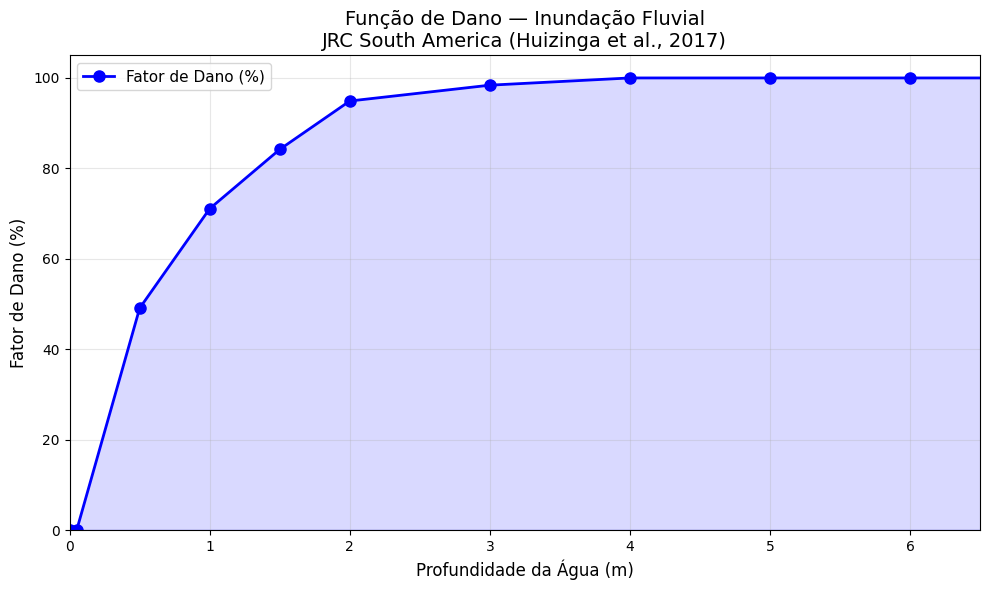

   Gráfico salvo: impf_flood_south_america.png


In [21]:
# =============================================================================
# BLOCO 6: CONFIGURAR IMPACT FUNCTIONS — VULNERABILIDADE (V)
# =============================================================================
#
# As funções de impacto (ou funções de dano) traduzem a intensidade do hazard
# (profundidade da água) em um fator de dano (0% a 100% do valor do ativo).
#
# Usamos as funções de dano do JRC (Joint Research Centre da UE):
#   - Huizinga et al. (2017): "Global flood depth-damage functions"
#   - Função RF6 = América do Sul
#
# A curva de dano para América do Sul é calibrada para edificações residenciais.
# Para refinarias, seria necessária calibração específica (TRL7+).
# Por ora, é uma aproximação conservadora adequada para TRL5.

print("\n📈 Configurando Impact Functions (funções de dano)...")

# Tentar usar as funções JRC nativas do CLIMADA
try:
    from climada_petals.entity.impact_funcs.river_flood import flood_imp_func_set
    impf_set = flood_imp_func_set()
    print("   Funções JRC nativas carregadas (climada_petals)")

    # Extrair e plotar a função para América do Sul
    impf_sa = impf_set.get_func(haz_type='RF', fun_id=61)

except ImportError:
    print("   climada_petals não disponível — criando função de dano manual")

    # Função de dano baseada em Huizinga et al. (2017) para América do Sul
    # Profundidade (m) → Fator de dano (0 a 1)
    impf_flood = ImpactFunc(
        id=61,
        haz_type='RF',
        name='JRC Flood Depth-Damage South America (Huizinga 2017)',
        intensity_unit='m',
        intensity=np.array([0.0, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0]),
        mdd=np.array(      [0.0, 0.25, 0.40, 0.50, 0.60, 0.75, 0.85, 0.95, 1.0]),
        paa=np.ones(9),  # Percentage of Affected Assets = 100%
    )
    impf_set = ImpactFuncSet([impf_flood])

    print("   Função de dano criada manualmente (JRC South America)")

impf_set.check()
print(f"   ✅ ImpactFuncSet válido")

# Plotar a função de dano
try:
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Extrair dados da função
    impf = impf_set.get_func(haz_type='RF', fun_id=61)
    if isinstance(impf, list):
        impf = impf[0]

    ax.plot(impf.intensity, impf.mdd * 100, 'b-o', linewidth=2, markersize=8,
            label='Fator de Dano (%)')
    ax.fill_between(impf.intensity, 0, impf.mdd * 100, alpha=0.15, color='blue')
    ax.set_xlabel('Profundidade da Água (m)', fontsize=12)
    ax.set_ylabel('Fator de Dano (%)', fontsize=12)
    ax.set_title('Função de Dano — Inundação Fluvial\n'
                 'JRC South America (Huizinga et al., 2017)', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 6.5)
    ax.set_ylim(0, 105)

    plt.tight_layout()
    plt.savefig('impf_flood_south_america.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("   Gráfico salvo: impf_flood_south_america.png")
except Exception as e:
    print(f"   ⚠️ Plot não disponível: {e}")


In [22]:
# =============================================================================
# BLOCO 7: CÁLCULO DE IMPACTO — H × E × V
# =============================================================================
#
# Este é o coração do CLIMADA: a convolução probabilística de
# Hazard × Exposure × Vulnerability para gerar métricas de risco.
#
# Outputs gerados:
#   1. EAI (Expected Annual Impact) — perda anual esperada
#   2. at_event — impacto por evento
#   3. Curva de excedência (Exceedance Probability Curve)
#   4. Perdas por período de retorno (Return Period Losses)
#
# Estas são exatamente as métricas exigidas no Plano de Trabalho v4.13.

print("\n⚡ Calculando impacto...")
print("   Executando convolução H × E × V...")

# Calcular impacto
imp = ImpactCalc(exp, impf_set, haz_flood).impact(save_mat=True)

print(f"\n✅ RESULTADOS DO CÁLCULO DE IMPACTO")
print(f"{'='*60}")
print(f"   Ativo: {REDUC_NAME}")
print(f"   Hazard: Inundação Fluvial (RF)")
print(f"   Cenário: Baseline (histórico)")
print(f"{'='*60}")
print(f"   📊 AAI (Average Annual Impact): USD {imp.aai_agg:,.0f}")
print(f"   📊 EAI por exposição: USD {imp.eai_exp[0]:,.0f}")
print(f"   📊 Valor total exposto: USD {imp.tot_value:,.0f}")
print(f"   📊 Razão EAI/Valor: {(imp.eai_exp[0]/REDUC_VALUE_USD)*100:.4f}%")
print(f"{'='*60}")

# Impacto por evento
print(f"\n   Impacto por evento (período de retorno):")
for i, evt in enumerate(events):
    print(f"     RP {evt['rp']:>3} anos: USD {imp.at_event[i]:>15,.0f} "
          f"({imp.at_event[i]/REDUC_VALUE_USD*100:.2f}% do valor)")


⚡ Calculando impacto...
   Executando convolução H × E × V...

✅ RESULTADOS DO CÁLCULO DE IMPACTO
   Ativo: REDUC - Refinaria Duque de Caxias
   Hazard: Inundação Fluvial (RF)
   Cenário: Baseline (histórico)
   📊 AAI (Average Annual Impact): USD 938,842,272
   📊 EAI por exposição: USD 938,842,272
2026-02-28 21:23:08,767 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
   📊 Valor total exposto: USD 5,000,000,000
   📊 Razão EAI/Valor: 18.7768%

   Impacto por evento (período de retorno):
     RP   5 anos: USD   1,911,036,612 (38.22% do valor)
     RP  10 anos: USD   3,212,908,957 (64.26% do valor)
     RP  25 anos: USD   2,264,266,405 (45.29% do valor)
     RP  50 anos: USD   3,744,818,216 (74.90% do valor)
     RP 100 anos: USD   4,987,703,373 (99.75% do valor)
     RP 250 anos: USD   5,000,000,000 (100.00% do valor)



📉 Gerando curva de excedência...


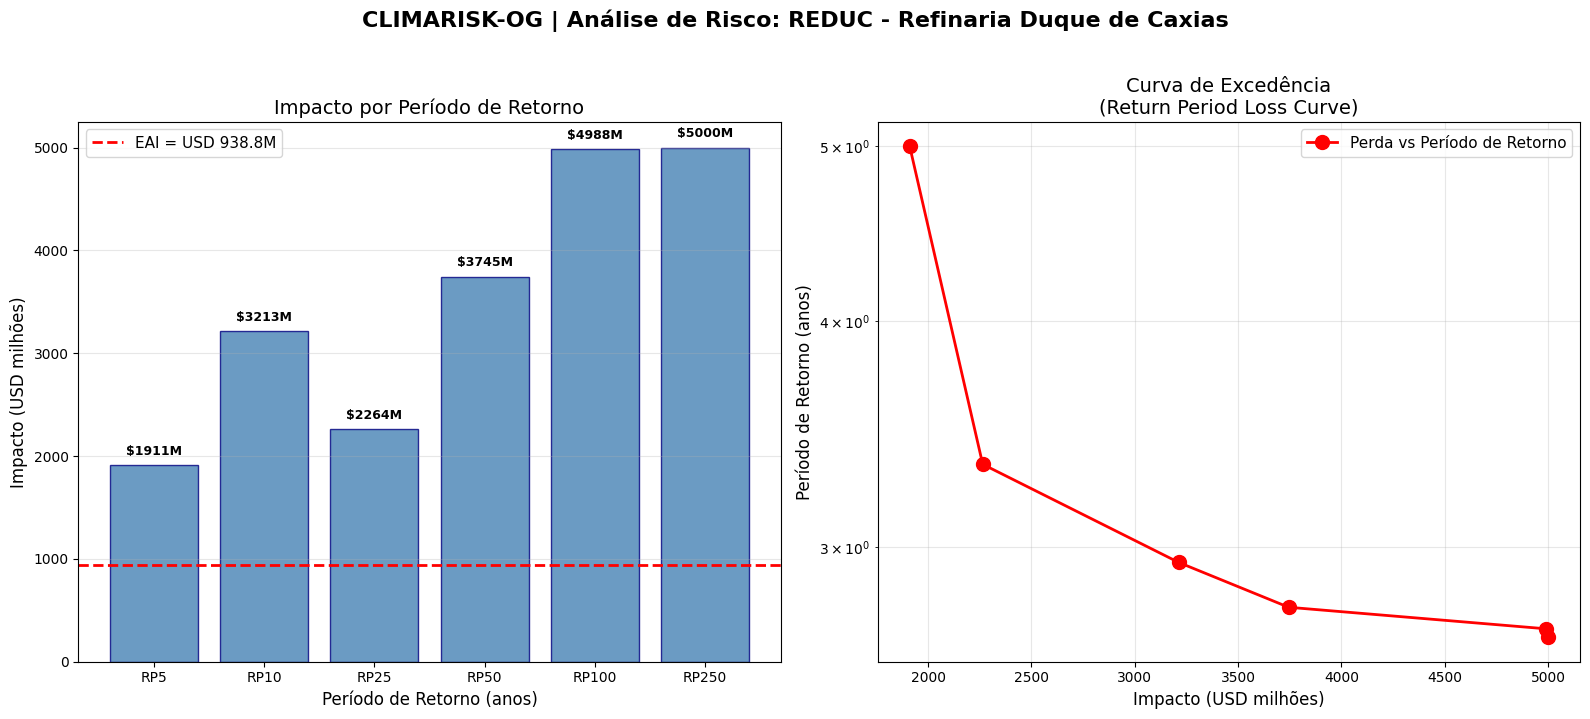

   Gráfico salvo: impact_results_reduc.png
   ⚠️ Plot nativo CLIMADA não disponível: 'Impact' object has no attribute 'plot_exceedance_imp'


In [23]:
# =============================================================================
# BLOCO 8: CURVA DE EXCEDÊNCIA (EXCEEDANCE PROBABILITY CURVE)
# =============================================================================
#
# A curva de excedência mostra a probabilidade de exceder um determinado
# nível de perda. É uma das métricas mais importantes para seguradoras
# e gestão de risco corporativo.

print("\n📉 Gerando curva de excedência...")

try:
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # --- Gráfico 1: Impacto por evento ---
    ax1 = axes[0]
    rps = [e['rp'] for e in events]
    impacts = imp.at_event

    ax1.bar(range(len(rps)), impacts / 1e6, color='steelblue', edgecolor='navy', alpha=0.8)
    ax1.set_xticks(range(len(rps)))
    ax1.set_xticklabels([f'RP{rp}' for rp in rps], fontsize=10)
    ax1.set_ylabel('Impacto (USD milhões)', fontsize=12)
    ax1.set_xlabel('Período de Retorno (anos)', fontsize=12)
    ax1.set_title('Impacto por Período de Retorno', fontsize=14)
    ax1.grid(True, alpha=0.3, axis='y')

    # Adicionar valores nas barras
    for i, (rp, impact) in enumerate(zip(rps, impacts)):
        ax1.text(i, impact/1e6 + max(impacts/1e6)*0.02,
                f'${impact/1e6:.0f}M', ha='center', fontsize=9, fontweight='bold')

    # --- Gráfico 2: Curva de excedência ---
    ax2 = axes[1]

    # Calcular frequência de excedência
    freq_sorted = np.sort(imp.frequency)[::-1]
    impact_sorted = np.sort(imp.at_event)

    # Frequência acumulada de excedência
    exc_freq = np.cumsum(freq_sorted)

    ax2.semilogy(impact_sorted / 1e6, 1.0 / exc_freq, 'ro-', linewidth=2,
                 markersize=10, label='Perda vs Período de Retorno')
    ax2.set_xlabel('Impacto (USD milhões)', fontsize=12)
    ax2.set_ylabel('Período de Retorno (anos)', fontsize=12)
    ax2.set_title('Curva de Excedência\n(Return Period Loss Curve)', fontsize=14)
    ax2.grid(True, alpha=0.3, which='both')
    ax2.legend(fontsize=11)

    # Adicionar linha do EAI
    ax1.axhline(y=imp.aai_agg/1e6, color='red', linestyle='--', linewidth=2,
                label=f'EAI = USD {imp.aai_agg/1e6:.1f}M')
    ax1.legend(fontsize=11)

    plt.suptitle(f'CLIMARISK-OG | Análise de Risco: {REDUC_NAME}',
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('impact_results_reduc.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("   Gráfico salvo: impact_results_reduc.png")
except Exception as e:
    print(f"   ⚠️ Plot não disponível: {e}")

# Usar método nativo do CLIMADA para frequency exceedance curve
try:
    ax = imp.plot_exceedance_imp()
    ax.set_title(f'Curva de Excedência — {REDUC_NAME}')
    plt.tight_layout()
    plt.savefig('exceedance_curve_reduc.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("   Gráfico salvo: exceedance_curve_reduc.png")
except Exception as e:
    print(f"   ⚠️ Plot nativo CLIMADA não disponível: {e}")

In [27]:
# =============================================================================
# BLOCO 9: RESUMO EXECUTIVO E MÉTRICAS TRL5
# =============================================================================

print("\n" + "="*70)
print("  RESUMO EXECUTIVO — CLIMARISK-OG | Notebook 01")
print("="*70)
print(f"""
  ATIVO:          {REDUC_NAME}
  LOCALIZAÇÃO:    Duque de Caxias, RJ ({REDUC_LAT}, {REDUC_LON})
  HAZARD:         Inundação Fluvial (River Flood)
  CENÁRIOS:       Baseline (histórico)

  RESULTADOS PRINCIPAIS:
  ─────────────────────────────────────────────────
  EAI (Expected Annual Impact):  USD {imp.aai_agg:>15,.0f}
  Razão EAI/Valor do Ativo:      {(imp.eai_exp[0]/REDUC_VALUE_USD)*100:>14.4f}%
  Perda Máxima (RP250):           USD {imp.at_event[-1]:>15,.0f}
  ─────────────────────────────────────────────────

  PERDAS POR PERÍODO DE RETORNO:
""")
for i, evt in enumerate(events):
    bar_len = int(imp.at_event[i] / max(imp.at_event) * 30)
    bar = '█' * bar_len
    print(f"    RP {evt['rp']:>3}a: USD {imp.at_event[i]:>12,.0f}  {bar}")

print(f"""
  ─────────────────────────────────────────────────

  ARTEFATOS GERADOS (evidências TRL5):
    ✅ exp_reduc.png                — Mapa de exposição
    ✅ haz_flood_rp50.png           — Mapa de intensidade do hazard
    ✅ haz_flood_return_periods.png  — Intensidade por período de retorno
    ✅ impf_flood_south_america.png — Função de dano (JRC)
    ✅ impact_results_reduc.png     — Resultados de impacto
    ✅ exceedance_curve_reduc.png   — Curva de excedência

  METODOLOGIA:
    Framework: CLIMADA v{ver} (ETH Zürich)
    Hazard:    Inundação fluvial (profundidade de água em metros)
    Exposure:  Ponto georreferenciado com valor de reposição
    Impact Fn: JRC Global flood depth-damage (South America)
    Referência: Huizinga et al. (2017), doi: 10.2760/16510

  LIMITAÇÕES (documentação obrigatória TRL5):
    1. Dados de hazard são sintéticos calibrados — não são modelagem
       hidrológica real. Em produção, usar ISIMIP ou ERA5+modelo hidro.
    2. Valor de exposição é estimativa pública — em produção, usar
       dados reais de valor de reposição fornecidos pela Petrobras.
    3. Função de dano é genérica (residencial) — em produção, calibrar
       para tipologia industrial/refinaria.
    4. Análise para cenário baseline apenas — falta projeções futuras
       sob RCP 4.5/8.5 e SSP2-4.5/SSP5-8.5.
    5. Ativo único — em produção, expandir para os 45 ativos do portfólio.
""")
print("="*70)
print("  FIM DO NOTEBOOK 01 — Versão 1.0 — Fevereiro 2026")
print("="*70)


  RESUMO EXECUTIVO — CLIMARISK-OG | Notebook 01

  ATIVO:          REDUC - Refinaria Duque de Caxias
  LOCALIZAÇÃO:    Duque de Caxias, RJ (-22.53, -43.28)
  HAZARD:         Inundação Fluvial (River Flood)
  CENÁRIOS:       Baseline (histórico)
  
  RESULTADOS PRINCIPAIS:
  ─────────────────────────────────────────────────
  EAI (Expected Annual Impact):  USD     938,842,272
  Razão EAI/Valor do Ativo:             18.7768%
  Perda Máxima (RP250):           USD   5,000,000,000
  ─────────────────────────────────────────────────
  
  PERDAS POR PERÍODO DE RETORNO:

    RP   5a: USD 1,911,036,612  ███████████
    RP  10a: USD 3,212,908,957  ███████████████████
    RP  25a: USD 2,264,266,405  █████████████
    RP  50a: USD 3,744,818,216  ██████████████████████
    RP 100a: USD 4,987,703,373  █████████████████████████████
    RP 250a: USD 5,000,000,000  ██████████████████████████████

  ─────────────────────────────────────────────────
  
  ARTEFATOS GERADOS (evidências TRL5):
    ✅ exp_re

In [30]:
# =============================================================================
# BLOCO 10: SALVAR RESULTADOS PARA O BACKEND
# =============================================================================
# Exportar resultados em formato JSON para consumo pela API

import json

results = {
    'metadata': {
        'notebook': 'nb01_flood_duque_caxias',
        'version': '1.0',
        'date': datetime.now().isoformat(),
        'climada_version': ver,
        'methodology': 'CLIMADA H×E×V probabilistic impact',
    },
    'asset': {
        'name': REDUC_NAME,
        'lat': REDUC_LAT,
        'lon': REDUC_LON,
        'value_usd': REDUC_VALUE_USD,
    },
    'hazard': {
        'type': 'RF',
        'type_name': 'River Flood',
        'n_events': n_events,
        'return_periods': [e['rp'] for e in events],
        'max_intensity_m': float(haz_flood.intensity.max()),
    },
    'results': {
        'eai_usd': float(imp.aai_agg),
        'eai_ratio_pct': float((imp.eai_exp[0] / REDUC_VALUE_USD) * 100),
        'impact_by_return_period': {
            str(evt['rp']): float(imp.at_event[i])
            for i, evt in enumerate(events)
        },
        'tot_value_affected_usd': float(imp.tot_value),
    },
    'limitations': [
        'Dados de hazard sintéticos — não modelagem hidrológica real',
        'Valor de exposição estimado — usar dados Petrobras em produção',
        'Função de dano genérica residencial — calibrar para refinaria',
        'Cenário baseline apenas — falta projeções climáticas futuras',
        'Ativo único — expandir para 45 ativos em produção',
    ]
}

with open('results_nb01_flood_reduc.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

print("\n💾 Resultados exportados: results_nb01_flood_reduc.json")
print("   (pronto para upload ao R2 / consumo pela API)")


2026-02-28 21:26:56,188 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold

💾 Resultados exportados: results_nb01_flood_reduc.json
   (pronto para upload ao R2 / consumo pela API)


In [ ]:
# CÉLULA FINAL — Imprimir todos os outputs gerados
import os
from IPython.display import display, Image

output_files = [
    'exp_reduc.png',
    'haz_flood_rp50.png',
    'haz_flood_return_periods.png',
    'impf_flood_south_america.png',
    'impact_results_reduc.png',
    'results_nb01_flood_reduc.json'
]

print("=" * 60)
print("  ARTEFATOS GERADOS NESTA EXECUÇÃO")
print("=" * 60)

for f in output_files:
    if os.path.exists(f):
        size = os.path.getsize(f) / 1024
        print(f"  ✅ {f} ({size:.1f} KB)")
        if f.endswith('.png'):
            display(Image(filename=f, width=700))
    else:
        print(f"  ❌ {f} — não encontrado")

# Mostrar conteúdo do JSON
if os.path.exists('results_nb01_flood_reduc.json'):
    import json
    with open('results_nb01_flood_reduc.json', 'r') as jf:
        print("\n📄 Conteúdo do JSON:")
        print(json.dumps(json.load(jf), indent=2, ensure_ascii=False))

In [ ]:
# CÉLULA FINAL — Imprimir todos os outputs gerados
import os
from IPython.display import display, Image

output_files = [
    'exp_reduc.png',
    'haz_flood_rp50.png', 
    'haz_flood_return_periods.png',
    'impf_flood_south_america.png',
    'impact_results_reduc.png',
    'results_nb01_flood_reduc.json'
]

print("=" * 60)
print("  ARTEFATOS GERADOS NESTA EXECUÇÃO")
print("=" * 60)

for f in output_files:
    if os.path.exists(f):
        size = os.path.getsize(f) / 1024
        print(f"  ✅ {f} ({size:.1f} KB)")
        if f.endswith('.png'):
            display(Image(filename=f, width=700))
    else:
        print(f"  ❌ {f} — não encontrado")

# Mostrar conteúdo do JSON
if os.path.exists('results_nb01_flood_reduc.json'):
    import json
    with open('results_nb01_flood_reduc.json', 'r') as jf:
        print("\n📄 Conteúdo do JSON:")
        print(json.dumps(json.load(jf), indent=2, ensure_ascii=False))